In [1]:
import pandas as pd
import numpy as np
import sklearn.base
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import hyperopt
import matplotlib.pyplot as plt

In [2]:
#задание количества выводимых на экран строк
pd.options.display.max_rows = 96
#создание датафрейма
df = pd.read_csv("data.csv")
#print(df.dtypes)

In [3]:
X = df.drop('Bankrupt?', axis=1).to_numpy()
y = df.loc[:,'Bankrupt?'].to_numpy()

In [5]:
print((df.loc[:,'Bankrupt?'] == 1).sum())
print((df.loc[:,'Bankrupt?'] == 0).sum())
#выравниваем вклад в функцию потерь позитивных и негативных данных
scale_pos_weight = (df.loc[:,'Bankrupt?'] == 0).sum()/(df.loc[:,'Bankrupt?'] == 1).sum()
print(scale_pos_weight)

220
6599
29.995454545454546


In [4]:
#Создали класс, реализующий ансамль LogisticRegression-моделей, обученных на случайных сбалансированных подвыборках
class ResampledEnsemble(sklearn.base.BaseEstimator):

    def __init__(self, n_estimators = 100, zeros_ratio = 1, scale_pos_weight = 1, power = 1, ensemble_quantile = None, column_probability = 1):
        self.n_estimators = n_estimators
        self.classes_ = np.array([0,1])
        self.zeros_ratio = zeros_ratio
        self.scale_pos_weight = scale_pos_weight
        self.power = power
        #добавляем вместо среднего арифметического квантиль
        self.ensemble_quantile = ensemble_quantile
        #Добавили рандомизацию по колонкам признака
        self.column_probability = column_probability

    def fit(self, X, y):
        self.estimators = []
        self.estimators_columns = []
        for i in range(self.n_estimators):
            #хранит индикатор того будет ли использоваться столбец данных
            outcome = np.random.binomial(n = 1, p = self.column_probability, size = X.shape[1])
            while outcome.sum() == 0: #индикатор того, что ни один столбец не выбран
                outcome = np.random.binomial(n = 1, p = self.column_probability, size = X.shape[1])
            columns = np.where(outcome == 1)[0]
            self.estimators_columns.append(columns)
            ones = y == 1
            num_ones = ones.sum()
            zeros_indexes = np.where(np.logical_not(ones))[0]
            zeros_subsample = np.random.choice(zeros_indexes, size = int(num_ones*self.zeros_ratio), replace=False, p=None)
            final_indexes = np.concatenate([np.where(ones)[0], zeros_subsample])
            # print(final_indexes)
            # print(X[final_indexes, columns])
            model = LogisticRegressionCV(penalty='l2', solver="saga", class_weight = {0: 1, 1: self.scale_pos_weight}, max_iter = 10000)
            #model.fit(X[final_indexes, :], y[final_indexes])
            model.fit(X[np.ix_(final_indexes, columns)], y[final_indexes])
            self.estimators.append(model)
            #print("Fitting of model number {} is finished".format(i))
            if model.classes_[0] > model.classes_[1]:
                raise Exception("Wrong order of classes")

    def predict_proba(self, X):
        results = np.zeros([self.n_estimators, X.shape[0], 2]) #количество строк в иксе, количество столбцов по числу классов [0] и [1]
        for i in range(self.n_estimators):
            results[i,:,:] = self.estimators[i].predict_proba(X[:, self.estimators_columns[i]])
        if self.ensemble_quantile is None:
            ensemble_results = np.mean(results**self.power, axis = 0)
        else:
            ensemble_results = np.quantile(results**self.power, self.ensemble_quantile, axis = 0)
        row_sums =  np.sum(ensemble_results, axis = 1)
        return ensemble_results/row_sums[:, None]

    def predict(self, X):
        res_classes = np.zeros(X.shape[0])
        results = self.predict_proba(X)
        for i in range(X.shape[0]):
            res_classes[i] = self.classes_[np.argmax(results[i,:])]
        return res_classes

In [23]:
X = df.drop('Bankrupt?', axis=1).to_numpy()
y = df.loc[:,'Bankrupt?'].to_numpy()

model = ResampledEnsemble(n_estimators = 3, column_probability = 0.5)
model.fit(X,y)
print("Predicted classes:", model.predict(X[range(5),:]))
print("Predicted scores of classes:\n", model.predict_proba(X[range(5),:]))

Predicted classes: [0. 0. 1. 1. 0.]
Predicted scores of classes:
 [[0.53131717 0.46868283]
 [0.52786894 0.47213106]
 [0.21241112 0.78758888]
 [0.24046899 0.75953101]
 [0.52885892 0.47114108]]


In [27]:
X = df.drop('Bankrupt?', axis=1).to_numpy()
y = df.loc[:,'Bankrupt?'].to_numpy()

#при zeros_ratio = 2 test_precision и test_recall почти сравнялись
model = ResampledEnsemble(n_estimators = 100, zeros_ratio = 2, column_probability = 0.05)
#следующий класс выступает в качестве указателя для кросс-валидации, определяет разбиение данных на подвыборки
cv = RepeatedKFold(n_splits = 5, n_repeats = 1, random_state = 1) #n_repeats - повторение функции кросс-валидации
n_scores = cross_validate(model, X, y, scoring = ['accuracy', 'precision', 'recall', 'f1'], cv = cv, n_jobs = 4)

for k in n_scores:
    print('{}: {:.3f} ({:.3f})'.format(k, n_scores[k].mean(), n_scores[k].std()))

fit_time: 54.853 (10.217)
score_time: 0.024 (0.003)
test_accuracy: 0.958 (0.006)
test_precision: 0.358 (0.056)
test_recall: 0.392 (0.091)
test_f1: 0.373 (0.070)


In [35]:
X = df.drop('Bankrupt?', axis=1).to_numpy()
y = df.loc[:,'Bankrupt?'].to_numpy()

#при zeros_ratio = 2 test_precision и test_recall почти сравнялись (около 0.3)
#добавим ensemble_quantile = 0.5 (test_recall уменьшился, стал 0.238), при 0.9 test_recall повысился, стал 0.407. При 0.95 test_precision уменьшился (стал 0.283), test_recall = 0.527. При 0.83 test_precision: 0.402, test_recall: 0.348. При 0.87 test_precision: 0.350, test_recall: 0.391. 
model = ResampledEnsemble(n_estimators = 100, zeros_ratio = 2, column_probability = 0.05, ensemble_quantile = 0.87)
#следующий класс выступает в качестве указателя для кросс-валидации, определяет разбиение данных на подвыборки
cv = RepeatedKFold(n_splits = 5, n_repeats = 1, random_state = 1) #n_repeats - повторение функции кросс-валидации
n_scores = cross_validate(model, X, y, scoring = ['accuracy', 'precision', 'recall', 'f1'], cv = cv, n_jobs = 4)

for k in n_scores:
    print('{}: {:.3f} ({:.3f})'.format(k, n_scores[k].mean(), n_scores[k].std()))

fit_time: 53.311 (5.937)
score_time: 0.030 (0.005)
test_accuracy: 0.957 (0.004)
test_precision: 0.350 (0.041)
test_recall: 0.391 (0.142)
test_f1: 0.353 (0.083)


In [26]:
X = df.drop('Bankrupt?', axis=1).to_numpy()
y = df.loc[:,'Bankrupt?'].to_numpy()

model = ResampledEnsemble(n_estimators = 20, zeros_ratio = 1, power=0.01)
cv = RepeatedKFold(n_splits = 5, n_repeats = 1, random_state = 1)
n_scores = cross_validate(model, X, y, scoring = ['accuracy', 'precision', 'recall', 'f1'], cv = cv, n_jobs = 4)

for k in n_scores:
    print('{}: {:.3f} ({:.3f})'.format(k, n_scores[k].mean(), n_scores[k].std()))

fit_time: 35.750 (2.848)
score_time: 0.016 (0.002)
test_accuracy: 0.708 (0.015)
test_precision: 0.049 (0.009)
test_recall: 0.442 (0.086)
test_f1: 0.088 (0.016)


In [27]:
X = df.drop('Bankrupt?', axis=1).to_numpy()
y = df.loc[:,'Bankrupt?'].to_numpy()

model = ResampledEnsemble(n_estimators = 20, zeros_ratio = 1, power=1, ensemble_quantile=0.5)
cv = RepeatedKFold(n_splits = 5, n_repeats = 1, random_state = 1)
n_scores = cross_validate(model, X, y, scoring = ['accuracy', 'precision', 'recall', 'f1'], cv = cv, n_jobs = 4)

for k in n_scores:
    print('{}: {:.3f} ({:.3f})'.format(k, n_scores[k].mean(), n_scores[k].std()))

fit_time: 43.706 (3.815)
score_time: 0.037 (0.037)
test_accuracy: 0.714 (0.018)
test_precision: 0.050 (0.007)
test_recall: 0.439 (0.082)
test_f1: 0.089 (0.014)


In [37]:
def extend_data(X):
    xcopy= X.copy()
    xsquares = xcopy**2
    return np.hstack([xcopy, xsquares])

In [40]:
X2 = extend_data(X)
y = df.loc[:,'Bankrupt?'].to_numpy()

model = ResampledEnsemble(n_estimators = 20, zeros_ratio = 1)
cv = RepeatedKFold(n_splits = 5, n_repeats = 1, random_state = 1)
n_scores = cross_validate(model, X2, y, scoring = ['accuracy', 'precision', 'recall', 'f1'], cv = cv, n_jobs = 4)

for k in n_scores:
    print('{}: {:.3f} ({:.3f})'.format(k, n_scores[k].mean(), n_scores[k].std()))

fit_time: 65.704 (7.108)
score_time: 0.015 (0.001)
test_accuracy: 0.728 (0.017)
test_precision: 0.048 (0.005)
test_recall: 0.394 (0.054)
test_f1: 0.085 (0.009)


Добавили рандомизацию по колонкам признака

In [6]:
X = df.drop('Bankrupt?', axis=1).to_numpy()
y = df.loc[:,'Bankrupt?'].to_numpy()

model = ResampledEnsemble(n_estimators = 5, zeros_ratio = 1)
cv = RepeatedKFold(n_splits = 5, n_repeats = 1, random_state = 1)
n_scores = cross_validate(model, X, y, scoring = ['accuracy', 'precision', 'recall', 'f1'], cv = cv, n_jobs = 4)

for k in n_scores:
    print('{}: {:.3f} ({:.3f})'.format(k, n_scores[k].mean(), n_scores[k].std()))

fit_time: 46.659 (8.558)
score_time: 0.012 (0.004)
test_accuracy: 0.710 (0.018)
test_precision: 0.051 (0.008)
test_recall: 0.457 (0.073)
test_f1: 0.092 (0.014)


In [30]:
#Создали класс, реализующий ансамль XGB-моделей, обученных на случайных сбалансированных подвыборках с ансамблирующей функцией в виде модели машинного обучения
class SmartResampledEnsemble(sklearn.base.BaseEstimator):

    def __init__(self, n_estimators = 100, zeros_ratio = 1, scale_pos_weight = 1, column_probability = 1):
        self.n_estimators = n_estimators
        self.classes_ = np.array([0,1])
        self.zeros_ratio = zeros_ratio
        self.scale_pos_weight = scale_pos_weight
        self.column_probability = column_probability

    def fit(self, X, y):
        self.estimators = []
        self.estimators_columns = []
        for i in range(self.n_estimators):
            #хранит индикатор того будет ли использоваться столбец данных
            outcome = np.random.binomial(n = 1, p = self.column_probability, size = X.shape[1])
            while outcome.sum() == 0: #индикатор того, что ни один столбец не выбран
                outcome = np.random.binomial(n = 1, p = self.column_probability, size = X.shape[1])
            columns = np.where(outcome == 1)[0]
            self.estimators_columns.append(columns)
            ones = y == 1
            num_ones = ones.sum()
            zeros_indexes = np.where(np.logical_not(ones))[0]
            zeros_subsample = np.random.choice(zeros_indexes, size=int(num_ones*self.zeros_ratio), replace=False, p=None)
            final_indexes = np.concatenate([np.where(ones)[0], zeros_subsample])

            model = LogisticRegressionCV(penalty='l2', solver="saga", class_weight = {0: 1, 1: self.scale_pos_weight}, max_iter = 10000)

            model.fit(X[np.ix_(final_indexes, columns)], y[final_indexes])
            self.estimators.append(model)
            #print("Fitting of model number {} is finished".format(i))
            if model.classes_[0] > model.classes_[1]:
                raise Exception("Wrong order of classes")
        results = np.zeros([X.shape[0], self.n_estimators])
        for i in range(self.n_estimators):
            results[:,i] = self.estimators[i].predict_proba(X[:, self.estimators_columns[i]])[:,1]
        self.ensemblingmodel = DecisionTreeClassifier(max_depth = 2*self.n_estimators)
        self.ensemblingmodel.fit(results, y)

    def predict_proba(self, X):
        results = np.zeros([X.shape[0], self.n_estimators])
        for i in range(self.n_estimators):
            results[:,i] = self.estimators[i].predict_proba(X[:, self.estimators_columns[i]])[:,1]
        ensemble_results = self.ensemblingmodel.predict_proba(results)
        return ensemble_results

    def predict(self, X):
        res_classes = np.zeros(X.shape[0])
        results = self.predict_proba(X)
        for i in range(X.shape[0]):
            res_classes[i] = self.classes_[np.argmax(results[i,:])]
        return res_classes

In [ ]:
#XGBClassifier() - ансамблирующая модель
X = df.drop('Bankrupt?', axis=1).to_numpy()
y = df.loc[:,'Bankrupt?'].to_numpy()

model = SmartResampledEnsemble(n_estimators = 3)
model.fit(X,y)
print("Predicted classes:", model.predict(X[range(5),:]))
print("Predicted scores of classes:\n", model.predict_proba(X[range(5),:]))

In [16]:
#XGBClassifier() - ансамблирующая модель
X = df.drop('Bankrupt?', axis=1).to_numpy()
y = df.loc[:, 'Bankrupt?'].to_numpy()

model = SmartResampledEnsemble(zeros_ratio = 2, column_probability = 0.05)
cv = RepeatedKFold(n_splits = 5, n_repeats = 1, random_state = 1)
n_scores = cross_validate(model, X, y, scoring=['accuracy', 'precision', 'recall', 'f1'], cv=cv, n_jobs=4)

for k in n_scores:
    print('{}: {:.3f} ({:.3f})'.format(k, n_scores[k].mean(), n_scores[k].std()))

fit_time: 107.919 (30.641)
score_time: 0.033 (0.004)
test_accuracy: 0.968 (0.004)
test_precision: 0.525 (0.130)
test_recall: 0.228 (0.030)
test_f1: 0.315 (0.049)


zeros_ratio = 2, column_probability = 0.05:
test_accuracy: 0.968 (0.004)
test_precision: 0.525 (0.130)
test_recall: 0.228 (0.030)
test_f1: 0.315 (0.049)

In [31]:
#sklearn.tree.DecisionTreeClassifier()
X = df.drop('Bankrupt?', axis=1).to_numpy()
y = df.loc[:,'Bankrupt?'].to_numpy()

model = SmartResampledEnsemble(n_estimators = 3)
model.fit(X,y)
print("Predicted classes:", model.predict(X[range(5),:]))
print("Predicted scores of classes:\n", model.predict_proba(X[range(5),:]))

Predicted classes: [1. 0. 1. 0. 0.]
Predicted scores of classes:
 [[0.         1.        ]
 [0.94822257 0.05177743]
 [0.         1.        ]
 [0.66666667 0.33333333]
 [0.94822257 0.05177743]]


In [32]:
#sklearn.tree.DecisionTreeClassifier()
X = df.drop('Bankrupt?', axis=1).to_numpy()
y = df.loc[:,'Bankrupt?'].to_numpy()

model = SmartResampledEnsemble()
cv = RepeatedKFold(n_splits = 5, n_repeats = 1, random_state = 1)
n_scores = cross_validate(model, X, y, scoring = ['accuracy', 'precision', 'recall', 'f1'], cv = cv, n_jobs = 4)

for k in n_scores:
    print('{}: {:.3f} ({:.3f})'.format(k, n_scores[k].mean(), n_scores[k].std()))

fit_time: 956.892 (164.156)
score_time: 0.062 (0.011)
test_accuracy: 0.930 (0.005)
test_precision: 0.066 (0.019)
test_recall: 0.088 (0.027)
test_f1: 0.075 (0.022)


In [5]:
#hyperopt
X = df.drop('Bankrupt?', axis=1).to_numpy()
y = df.loc[:,'Bankrupt?'].to_numpy()

def hyperopt_train_test(params):
    clf = ResampledEnsemble(n_estimators = 5, **params)
    return sklearn.model_selection.cross_val_score(clf, X, y, scoring = "f1").mean()

params_space = {
    'zeros_ratio': hyperopt.hp.lognormal('zeros_ratio', 0, 1),
    'scale_pos_weight': hyperopt.hp.lognormal('scale_pos_weight', 0, 1),
    'ensemble_quantile': hyperopt.hp.uniform('ensemble_quantile', 0, 1),
    'column_probability': hyperopt.hp.uniform('column_probability', 0, 1),

}
def f(params):
    acc = hyperopt_train_test(params)
    return {'loss': -acc, 'status': hyperopt.STATUS_OK}

trials = hyperopt.Trials() #объект для сбора информации об ошибках
best = hyperopt.fmin(f, params_space, algo = hyperopt.tpe.suggest, max_evals = 30, trials = trials)
print(best)

 57%|█████▋    | 17/30 [28:30<22:07, 102.14s/trial, best loss: -0.08781549028009983] 

C:\Users\guzra\PycharmProjects\Diploma\files\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,



 60%|██████    | 18/30 [28:37<14:42, 73.57s/trial, best loss: -0.10676729559748428] 

C:\Users\guzra\PycharmProjects\Diploma\files\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,

C:\Users\guzra\PycharmProjects\Diploma\files\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,

C:\Users\guzra\PycharmProjects\Diploma\files\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,

C:\Users\guzra\PycharmProjects\Diploma\files\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,

C:\Users\guzra\PycharmProjects\Diploma\files\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  C

 67%|██████▋   | 20/30 [29:51<08:47, 52.76s/trial, best loss: -0.11773864816343564]

C:\Users\guzra\PycharmProjects\Diploma\files\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,

C:\Users\guzra\PycharmProjects\Diploma\files\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,

C:\Users\guzra\PycharmProjects\Diploma\files\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,

C:\Users\guzra\PycharmProjects\Diploma\files\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,

C:\Users\guzra\PycharmProjects\Diploma\files\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  C

 70%|███████   | 21/30 [36:27<23:20, 155.61s/trial, best loss: -0.11773864816343564]

C:\Users\guzra\PycharmProjects\Diploma\files\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
4 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\guzra\PycharmProjects\Diploma\files\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\guzra\AppData\Local\Temp\ipykernel_16840\2001432481.py", line 28, in fit
    zeros_subsample = np.random.choice(zeros_indexes, size = int(num_ones*self.zeros_ratio), replace=False, p=None)
  File "mtrand.pyx", line 965, in numpy.random.mtrand.RandomState.c

 77%|███████▋  | 23/30 [36:35<09:59, 85.63s/trial, best loss: -0.11773864816343564] 

C:\Users\guzra\PycharmProjects\Diploma\files\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,

C:\Users\guzra\PycharmProjects\Diploma\files\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,

C:\Users\guzra\PycharmProjects\Diploma\files\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,

C:\Users\guzra\PycharmProjects\Diploma\files\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,

C:\Users\guzra\PycharmProjects\Diploma\files\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  C

100%|██████████| 30/30 [53:00<00:00, 106.03s/trial, best loss: -0.13289528267264034]
{'column_probability': 0.012093173907798571, 'ensemble_quantile': 0.9721770712771785, 'scale_pos_weight': 17.206409737540476, 'zeros_ratio': 17.156791008458654}


C:\Users\guzra\PycharmProjects\Diploma\files\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\guzra\PycharmProjects\Diploma\files\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\guzra\AppData\Local\Temp\ipykernel_16840\2001432481.py", line 28, in fit
    zeros_subsample = np.random.choice(zeros_indexes, size = int(num_ones*self.zeros_ratio), replace=False, p=None)
  File "mtrand.pyx", line 965, in numpy.random.mtrand.RandomState.c

In [6]:
def plot_trials(trials, param):
    f, ax = plt.subplots(1)
    xs = [t["tid"] for t in trials.trials]
    ys = [t['misc']['vals'][param] for t in trials.trials]
    zs = np.array([-t["result"]['loss'] for t in trials.trials])

    image = ax.scatter(xs, ys, c = zs, s = 100*zs+5, linewidth = 1.5 , alpha = 1)
    ax.set_xlabel('iteration', fontsize = 8)
    ax.set_ylabel(param, fontsize = 8)
    f.colorbar(image)

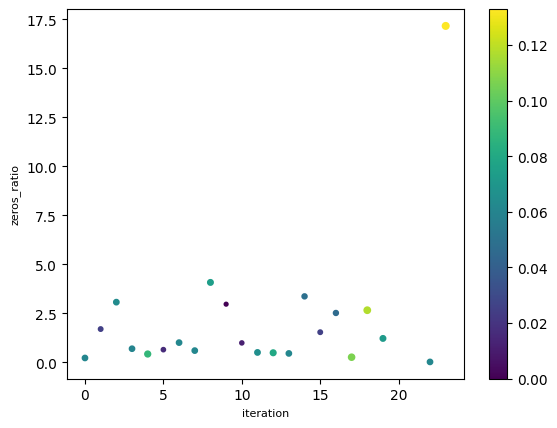

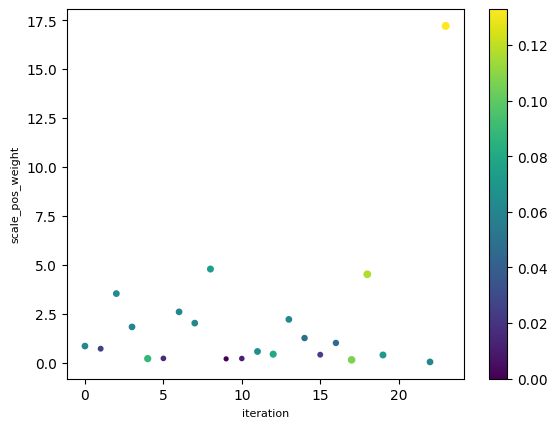

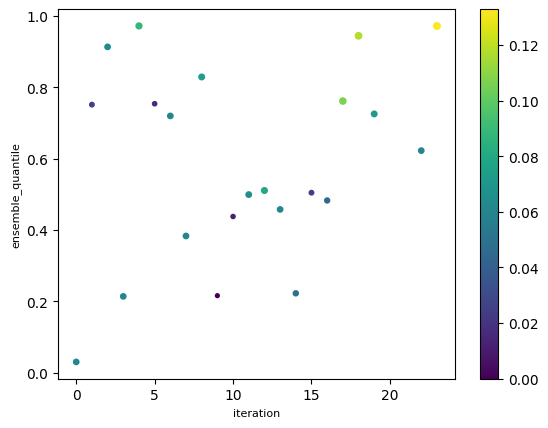

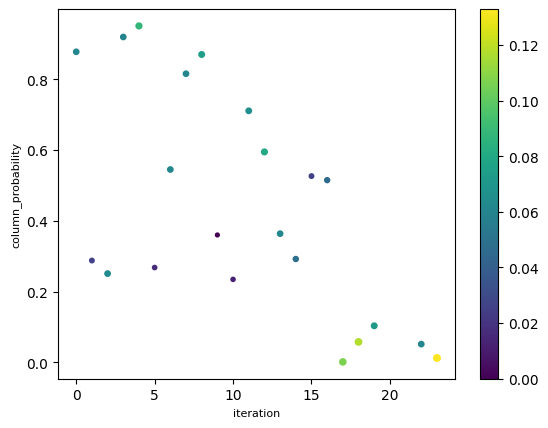

In [7]:
for params in params_space:
    plot_trials(trials, params)